In [3]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 16 # change it with respect to the desired class
IMG_SIZE = 48 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1
from keras.applications import VGG16

In [2]:
# import os

# directory_list = list()
# # folder_path = "/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop"
# folder_path = "/home/atif/machine_learning_stuff/ml_image/train_image_AI_reduced/new_method/"
# for root, dirs, files in os.walk(folder_path, topdown=False):
#     for name in dirs:
#         directory_list.append(os.path.join(root, name))

# print(directory_list)

In [49]:
import os
folder_path = "/home/atif/machine_learning_stuff/ml_image/train_image_AI_reduced/new_method/"
files=[]
files = [f for f in sorted(os.listdir(folder_path))]
print(files)

print(type(files))
print(len(files))

['CalgonitFinish', 'CalgonitFinishKlarSpueler', 'CalgonitFinishMaschinePfleger', 'CalgonitFinishSpeizalSalz', 'CalgonitFinishVorratspack', 'DenkmitAllzweckReiniger', 'DenkmitEdelstahlReiniger', 'DenkmitEdelstahlReinigerSpray', 'DenkmitEntkalker', 'DenkmitGeschirReiniger', 'DenkmitGeschirReinigerClassic', 'DenkmitGeschirReinigerNature', 'DenkmitGeschirreinigerEvo', 'DenkmitMaschinePfleger', 'DenkmitSpeizalSalz', 'SomatClassic']
<class 'list'>
16


# trained model save

In [5]:
save_model_path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [6]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("current time:", current_time)

current time: 2019-10-21 20:06:17


# dataset generates with KERAS IMAGE DATAGENERATOR

In [50]:
NUM_CLASSES = len(files)
print(NUM_CLASSES)

16


In [51]:
batch_size = 32
epochs = 20

In [73]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
# train_datagen = ImageDataGenerator(rescale=1/255)
train_datagen = ImageDataGenerator(rescale= None)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(folder_path,  # This is the source directory for training images
        target_size=(IMG_SIZE, IMG_SIZE),  # All images will be resized to 200 x 200
        batch_size=batch_size,color_mode="rgb",
#         Specify the classes explicitly
#         classes = ['daisy','dandelion','rose','sunflower','tulip'],
        classes = files,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical',seed=42)

Found 480 images belonging to 16 classes.


# Image preprocessing with former method

In [79]:
def preprocess_img(img):
#     # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

#     # central scrop
#     min_side = min(img.shape[:-1])
#     centre = img.shape[0]//2, img.shape[1]//2
#     img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1) # this lin is doing the channel fisrt operation

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [80]:
imgs = []
labels = []
root_dir = "/home/atif/machine_learning_stuff/ml_image/train_image_AI_reduced/former_method/"
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*')) #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%120 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 120/480
Processed 240/480
Processed 360/480
Processed 480/480


In [81]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (480, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (480, 16)  type:  <class 'numpy.ndarray'>


# model declaration

In [82]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [83]:
# model.summary()

# train with new method

In [76]:
total_sample=train_generator.n

In [77]:
print(type(total_sample))
print(total_sample)

<class 'int'>
480


In [78]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(total_sample/batch_size),  
        epochs= epochs,
        verbose=1, shuffle=True)
# callbacks=[LearningRateScheduler(lr_schedule),
#            ModelCheckpoint(save_model_path+str(current_time)+'_new_model_epoch_'+str(epochs)+'.h5', save_best_only=True)])

Epoch 1/20
15/15 [==============================] - 1s 77ms/step - loss: 14.7591 - acc: 0.0583
Epoch 2/20
15/15 [==============================] - 0s 30ms/step - loss: 15.1107 - acc: 0.0625
Epoch 3/20
15/15 [==============================] - 1s 34ms/step - loss: 15.1107 - acc: 0.0625
Epoch 4/20
15/15 [==============================] - 0s 33ms/step - loss: 15.1107 - acc: 0.0625
Epoch 5/20
15/15 [==============================] - 1s 34ms/step - loss: 15.1107 - acc: 0.0625
Epoch 6/20
15/15 [==============================] - 0s 33ms/step - loss: 15.1107 - acc: 0.0625
Epoch 7/20
15/15 [==============================] - 0s 33ms/step - loss: 15.1107 - acc: 0.0625
Epoch 8/20
15/15 [==============================] - 0s 33ms/step - loss: 15.1107 - acc: 0.0625
Epoch 9/20
15/15 [==============================] - 1s 34ms/step - loss: 15.1107 - acc: 0.0625
Epoch 10/20
15/15 [==============================] - 1s 34ms/step - loss: 15.1107 - acc: 0.0625
Epoch 11/20
15/15 [==============================

dict_keys(['loss', 'acc'])
dict_keys(['loss', 'acc'])


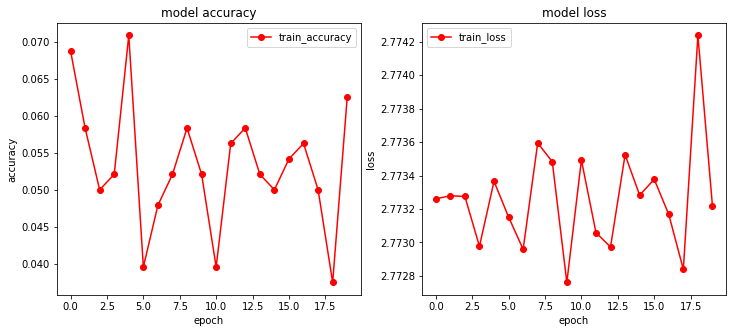

In [69]:
print(history.history.keys())
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'], '-o', color = 'red')
# plt.plot(history.history['val_acc'],'-^', color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
# plt.savefig(path+str(current_time)+'_epoch_vs_accuracy.jpg')
# plt.show()

# plt.figure()

print(history.history.keys())
plt.subplot(1,2,2)
# summarize history for accuracy
plt.plot(history.history['loss'],'-o', color = 'red')
# plt.plot(history.history['val_loss'],'-^', color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
# plt.savefig(path+str(current_time)+'_epoch_vs_loss.jpg')
plt.rcParams['figure.figsize'] =(12,5)
plt.show()

In [60]:
model.save(save_model_path+"MODEL_NEW_WAY.h5")
from keras.models import load_model
load_model = load_model(save_model_path+"MODEL_NEW_WAY.h5")

# train with former method

In [84]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
#           validation_split=0.2,
                         verbose=2, shuffle=True)
          #np.resize(img, (-1, <image shape>)
#           callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+str(current_time)+'_TEST_FORMER_model_epoch_'+str(epochs)+'.h5', save_best_only=True)])

Epoch 1/20
 - 1s - loss: 2.7737 - acc: 0.0583
Epoch 2/20
 - 0s - loss: 2.7679 - acc: 0.0542
Epoch 3/20
 - 0s - loss: 2.7563 - acc: 0.0542
Epoch 4/20
 - 0s - loss: 2.7419 - acc: 0.0646
Epoch 5/20
 - 0s - loss: 2.6734 - acc: 0.0479
Epoch 6/20
 - 0s - loss: 2.5154 - acc: 0.1375
Epoch 7/20
 - 0s - loss: 2.1857 - acc: 0.2479
Epoch 8/20
 - 0s - loss: 2.7056 - acc: 0.0875
Epoch 9/20
 - 0s - loss: 2.7896 - acc: 0.0521
Epoch 10/20
 - 0s - loss: 2.7769 - acc: 0.0625
Epoch 11/20
 - 0s - loss: 2.7539 - acc: 0.0729
Epoch 12/20
 - 0s - loss: 2.6777 - acc: 0.0729
Epoch 13/20
 - 0s - loss: 2.4861 - acc: 0.0958
Epoch 14/20
 - 0s - loss: 2.1330 - acc: 0.2104
Epoch 15/20
 - 0s - loss: 1.7834 - acc: 0.3708
Epoch 16/20
 - 0s - loss: 1.2740 - acc: 0.5833
Epoch 17/20
 - 0s - loss: 0.6785 - acc: 0.8000
Epoch 18/20
 - 0s - loss: 0.6480 - acc: 0.8229
Epoch 19/20
 - 0s - loss: 0.1839 - acc: 0.9583
Epoch 20/20
 - 0s - loss: 0.4808 - acc: 0.8979


In [45]:
model.save(save_model_path+"MODEL_OLD_WAY.h5")
from keras.models import load_model
load_model = load_model(save_model_path+"MODEL_OLD_WAY.h5")

In [46]:
import pandas as pd
import cv2
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_file_same_number_reduced.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
#     X_test.append(cv2.imread(img_path))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  calgonit_finish_speizalsalz (3).jpg 	 classId:  3
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  34_SM_DenkMitEdelstahlReinigerSpray_20_33_90_60_lit_cropped.jpg 	 classId:  6
filename:  somat_3.jpg 	 classId:  15
filename:  calgonit_finish_speizalsalz (4).jpg 	 classId:  3
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_hygiene_Allzweck_reiniger (3).jpg 	 classId:  12
filename:  denkmit_mascine_pfleger (1).jpg 	 classId:  13
filename:  calgonit_finish_klarspueler (1).jpg 	 classId:  1
filename:  calgonit_finish_classic (1).jpg 	 classId:  0
filename:  denkmit_geschirr_reiniger_NATURE (5).jpg 	 classId:  11
filename:  denkmit_geschirr_reiniger_multipower (1).jpg 	 classId:  8
filename:  denkmit_spezalsalz (1).jpg 	 classId:  14
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  Denkmit_geschirr_reiniger_classic (1).jpg 	 classId:  9
filename:  calgonit_finish_vorratspack.jpg 	 classId:  4
filename:  2_SM_CalgonitFinishV

In [47]:
print(type(X_test), X_test.ndim, X_test.shape)
print(type(y_test), y_test.ndim, y_test.shape)

<class 'numpy.ndarray'> 4 (32, 3, 48, 48)
<class 'numpy.ndarray'> 1 (32,)


In [61]:
y_pred = model.predict_classes(X_test)
# y_pred = load_model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.0625


In [42]:
import pandas as pd
import cv2
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_file_same_number_reduced.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
#     X_test.append(preprocess_img(io.imread(img_path)))
    X_test.append(cv2.imread(img_path))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  calgonit_finish_speizalsalz (3).jpg 	 classId:  3
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  34_SM_DenkMitEdelstahlReinigerSpray_20_33_90_60_lit_cropped.jpg 	 classId:  6
filename:  somat_3.jpg 	 classId:  15
filename:  calgonit_finish_speizalsalz (4).jpg 	 classId:  3
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_hygiene_Allzweck_reiniger (3).jpg 	 classId:  12
filename:  denkmit_mascine_pfleger (1).jpg 	 classId:  13
filename:  calgonit_finish_klarspueler (1).jpg 	 classId:  1
filename:  calgonit_finish_classic (1).jpg 	 classId:  0
filename:  denkmit_geschirr_reiniger_NATURE (5).jpg 	 classId:  11
filename:  denkmit_geschirr_reiniger_multipower (1).jpg 	 classId:  8
filename:  denkmit_spezalsalz (1).jpg 	 classId:  14
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  Denkmit_geschirr_reiniger_classic (1).jpg 	 classId:  9
filename:  calgonit_finish_vorratspack.jpg 	 classId:  4
filename:  2_SM_CalgonitFinishV

# test with test_generator method of keras

In [87]:
test_image_dir = '/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'
test_datagen = ImageDataGenerator(rescale=None)

test_generator = test_datagen.flow_from_directory(
    directory= test_image_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 0 images belonging to 0 classes.


In [90]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

In [95]:
predicted_class_indices=np.argmax(pred,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(16),
                  range(16))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(16)
figure = ax.get_figure()    
# figure.savefig('12_sep_general_new_model_no_augmentation_confusion.png', dpi=400)
